# First we solve the linear regression problem

In [3]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import daft

In [2]:
import theano
theano.config.warn.round=False

setting up and fitting linear model

In [4]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0,1,n)
y = _a*x + _b + np.random.randn(n)

In [5]:
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal("a", mu=0, sd=100)
    b = pm.Normal("b", mu=0, sd=100)
    sigma = pm.HalfNormal("sigma", sd=1)
    
    y_est = a*x + b
    likelihood = pm.Normal("y", mu=y_est, sd=sigma, observed=y)
    
    trace = pm.sample(niter, random_seed=123)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:24<00:00, 1701.00draws/s]
The acceptance probability does not match the target. It is 0.882890007545778, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921780943969211, but should be close to 0.8. Try to increase the number of tuning steps.


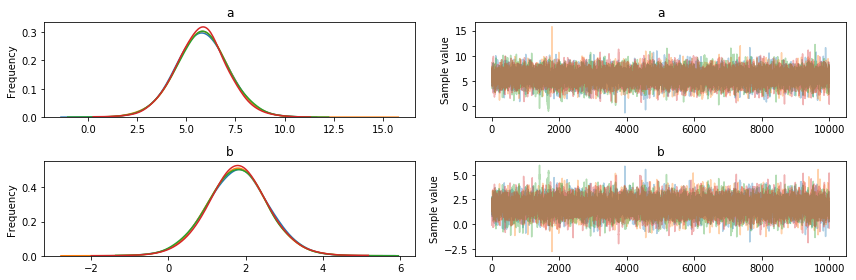

In [6]:
t = trace[niter//2:]
pm.traceplot(trace,varnames=["a","b"])
pass

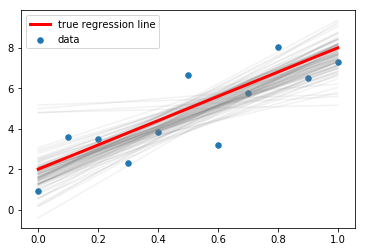

In [7]:
plt.scatter(x,y,s=30,label="data")
for a_, b_ in zip(t["a"][-100:], t["b"][-100:]):
    plt.plot(x,a_*x + b_, c="gray", alpha=0.1)
plt.plot(x, _a*x + _b, label="true regression line", lw=3., c="red")
plt.legend(loc="best")
pass

# the model problem

true model: $ y' = \theta y$, where $y(t_i) = f(\theta, i) = e^{\theta t_i}$

observations: $ z_i = y_i + \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0,\sigma)$

We can therefore see that the linear regression model has a lot of similarities, e.g., the likelihood for the model problem is 
$$P(z|\theta) = \mathcal{N}(z | y_i, \sigma)$$

we also assume a "simple" prior for $\theta$, naimly, $$P(\theta) = \mathcal{N}(0,100)$$

and for $\sigma$: 
$$P(\sigma) = \mathcal{N}(0,1)$$

### First assume only 1 observation of the time series


In [156]:
# generate observation
def gen_obs(N_t = 11, N_data=1):
    _theta = -2.5
    x = np.linspace(0,1,N_t)
    sigma = 0.5
    y = np.exp(_theta*x)
    z = y + np.random.normal(loc=0,
                             scale=sigma,
                             size=N_t*N_data).reshape(N_data,N_t)
    return(sigma, x, y, z)

np.random.seed(123)
N_data = 1
N_t = 101
sigma, x, y, z = gen_obs(N_t=N_t, N_data=N_data)

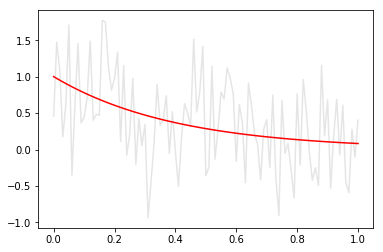

In [158]:
for i in range(N_data):
    plt.plot(x, z[i,:],'gray',alpha=0.2)

plt.plot(x,y, "r")
pass

In [162]:
# infer parameters
def modelInfer(x,sigma,z):
    niter = 10000
    with pm.Model() as modelProblem:
        theta = pm.Normal("theta", mu=0, sd=100)
        #sigma = pm.HalfNormal("sigma", sd=1)
    
        z_est = np.exp(theta*x)
        likelihood = pm.Normal("z", mu=z_est, sd=sigma, observed=z)
    
        trace =pm.sample(niter, random_seed=123)
    return(modelProblem, trace)

In [163]:
model, trace = modelInfer(x,sigma,z)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:28<00:00, 1491.50draws/s]


In [191]:
def post_mean(trace):
    tt = trace[niter//2:]
    theta_mean = np.mean(tt["theta"])
    return(theta_mean)

In [192]:
post_mean(trace)

-2.422138849452514

In [180]:
def plotit(model, trace):
    print("traceplot")
    tt = trace[niter//2:]
    pm.traceplot(trace, varnames=["theta"], figsize=[16,9])
    plt.show()
    
    print("distplot")
    sns.distplot(tt["theta"])
    theta_mean = np.mean(tt["theta"])
    plt.axvline(x=theta_mean, color="red")
    print("posterior mean: ", theta_mean)
    pass

traceplot


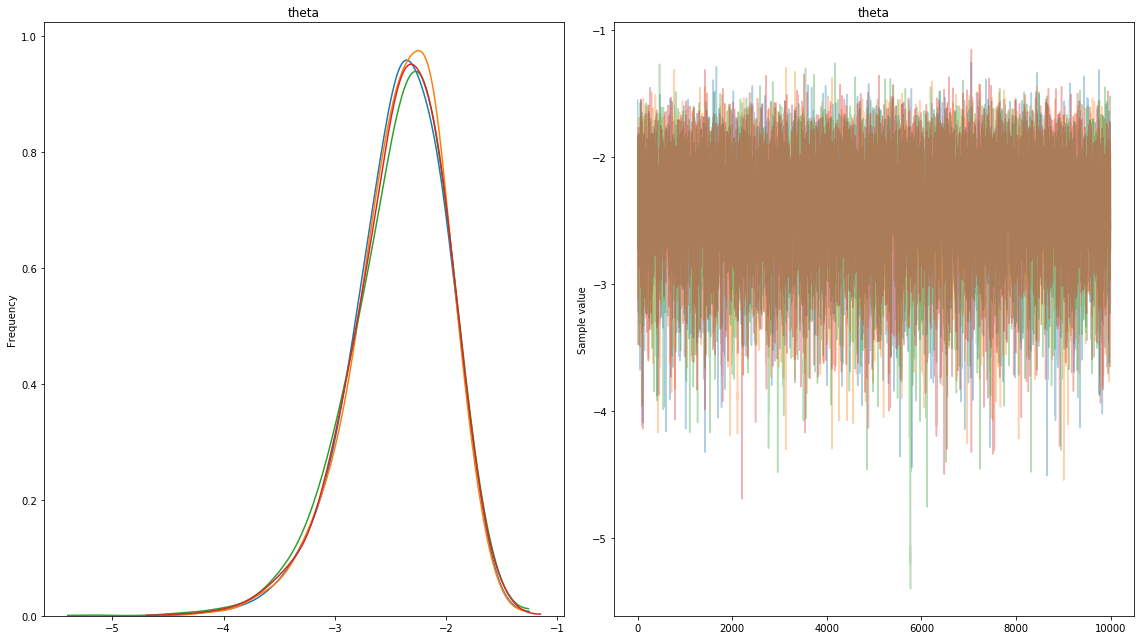

distplot
posterior mean:  -2.422138849452514


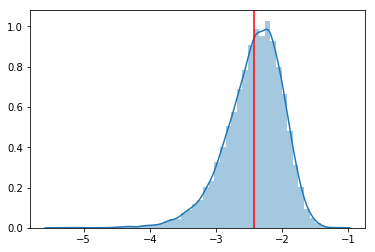

In [181]:
plotit(model,trace)

### now increase the number of observations, $N_\text{data}$
how does the mean behave?

In [193]:
def comp_bias(trace, truth=-2.5):
    bias = post_mean(trace) - truth
    return(bias)

In [194]:
comp_bias(trace)

0.07786115054748599

In [200]:
N_t_vec = np.linspace(11,1001,4, dtype = int)

bias_N = np.empty([len(N_data_vec), len(N_t_vec)])


In [207]:
bias_N.shape

(5, 4)

In [211]:
bias_N[4,1]

8.0

In [213]:
N_data_vec = np.logspace(0,2,5, dtype = int)
N_t_vec = np.linspace(11,1001,4, dtype = int)

bias_N = np.empty([len(N_data_vec), len(N_t_vec)])

np.random.seed(123)
for i in range(len(N_t_vec)):
    N_t = N_t_vec[i]
    print("T: ", N_t)
    for j in range(len(N_data_vec)):
        N_data = N_data_vec[j]
        print("N: ", N_data)
        
        # generate observation
        sigma, x, y, z = gen_obs(N_t=N_t, N_data=N_data)
    
        # infer parameters
        #model, trace = modelInfer(x,sigma,z)
        
        # compute |bias|
        print(i,j)
        bias_N[i,j] = i*j #comp_bias(trace=trace)
    
print("done")        

T:  11
N:  1
0 0
N:  3
0 1
N:  10
0 2
N:  31
0 3
N:  100
0 4


IndexError: index 4 is out of bounds for axis 1 with size 4

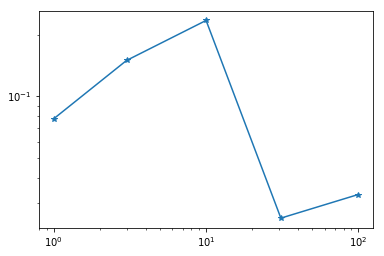

In [197]:
plt.loglog(N_data_vec, np.abs(bias_N), '*-')